# Модуль 9. **Підбір гіперпараметрів НМ**

In [190]:
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist

# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import EarlyStopping

import keras

from keras.layers import Dense, Dropout
from keras.models import Sequential

from keras import optimizers
from keras import losses
from keras import metrics
import copy

In [191]:
# константи кольору
YELLOW = "\033[33m"
LIGHTBLUE = "\033[94m"
GRAY_BACK = "\033[100m"
RESET = "\033[0m"

### Завдання

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету _fasion_mnist_ (https://www.tensorflow.org/datasets/catalog/fashion_mnist).

Вам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно 91%. Точність вашої моделі повинна бути не нижчою за цей показник. Щоб досягти таких значень вам знадобиться поекспериментувати з гіперпараметрами мережі:

* кількість шарів;
* кількість нейронів;
* функції активації;
* кількість епох;
* розмір батчу;
* вибір оптимізатора;
* різні техніки регуляризації і т.д.

Використайте вивчені техніки виявлення проблем навчання нейронної мережі, і потім поекспериментуйте.

    Завантаження та аналіз даних

In [192]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

In [193]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [194]:
# from https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md#labels
labels_description = {
    "Label": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    "Description": [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ],
}

labels = pd.DataFrame(labels_description)

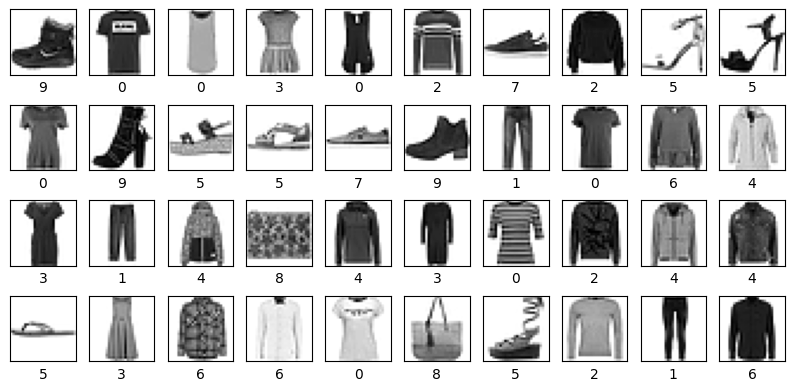

 Label Description
     0 T-shirt/top
     1     Trouser
     2    Pullover
     3       Dress
     4        Coat
     5      Sandal
     6       Shirt
     7     Sneaker
     8         Bag
     9  Ankle boot


In [195]:
plt.figure(figsize=(10, 6))
for i in range(40):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show() 

print(labels.to_string(index=False))

    Функція друку поточних параметрів

In [196]:
def print_parameters(parameters: dict, text_='Поточні параметри:'):
    print(f"{LIGHTBLUE}{text_}{RESET}")
    # print("-" * 18)
    for k, val in parameters.items():
        print(f" {k} \t= {YELLOW}{val}{RESET}")

    Функція відображення графіків історії точності та втрат

In [197]:
def plt_history(history, params):

    dict_data = {
        "accuracy": "Точність на тренувальному наборі",
        "val_accuracy": "Точність на тестовому наборі",
        "loss": "Втрати на тренувальному наборі",
        "val_loss": "Втрати на тестовому наборі",
    }
    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    print_parameters(params)
    
    for data_, label_ in dict_data.items():
        plt.plot(
            epochs,
            history.history[data_],
            color=color_loss if (data_[-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (data_[:3] == "val") else linestyle_train,
            label=label_,
        )

    # plt.title("Точність та втрати на тренувальному та тестовому наборах")
    plt.xlabel("Епоха")
    plt.ylabel("Метрика")
    plt.legend()
    plt.show()

    Базова модель

In [198]:
# TODO розібратися
# # Визначте вхідний шар
# inputs = Input(shape=(28, 28))

# # Додайте шари до моделі
# x = layers.Flatten()(inputs)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.2)(x)
# outputs = layers.Dense(10, activation="softmax")(x)

# # Створіть модель
# model = Model(inputs, outputs)

In [199]:
# заглушка - щоб прибрати UserWarning
# model_ = models.Sequential(
#     [
#         layers.Flatten(input_shape=(28, 28)),
#         # Do not pass an `input_shape`/`input_dim` argument to a layer. 
#         # When using Sequential models, prefer using an `Input(shape)` object 
#         # as the first layer in the model instead.
#         layers.Dense(128, activation="relu"),
#         layers.Dropout(0.2),
#         layers.Dense(10, activation="softmax"),
#     ]
# )

# model_.compile(
#     optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
# )

# history = model_.fit(
#     train_images,
#     train_labels,
#     epochs=10,
#     batch_size=128,
#     validation_split=0.2,
#     verbose=0,
# )

# plt_history(
#     history,
#     {
#         "epochs": 10,
#         "batch_size": 128,
#         "dropout_rate": 0.2,
#         "loss_function": "sparse_categorical_crossentropy",
#         "optimizer": "adam",
#         "hidden_units": 128,
#         "activation": "relu",
#         "metrics": ["accuracy"],
#     },
# )

# model.save("my_model.keras")

**Функція пошуку оптимальних параметрів**

      Аргументи: 
1. Набори даних для навчання і валідації
2. Параметри для тренування моделі
3. Оптимальні параметри. Спочатку "зі стелі", під час аналізу змінюються на оптимальні.
4. Послідовність параметрів, що мають перевірятися.
5. Функція, що містить модель для тренування

In [200]:
def find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    train_model_func,
    verbose=0,
):

    best_accuracy = 0.0
    best_parameters = {}

    for param in study_sequence:
        print(f"{GRAY_BACK}{"=" * 50}{RESET}")
        print(f"Пошук оптимального значення параметра: {YELLOW}{param} {RESET}")
        print(f"{GRAY_BACK}{"=" * 50}{RESET}")
        param_values = parameters[param]
        best_value = optimal_parameters[param]
        for value in param_values:
            optimal_parameters[param] = value
            print("-" * 50)
            print(f"Тестується значення: {YELLOW}{param} = {value}{RESET}")
            print("-" * 50)
            model, history, test_acc, train_acc = train_model_func(
                train_images,
                train_labels,
                test_images,
                test_labels,
                verbose=verbose,
                **optimal_parameters,
            )
            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value
            # Plotting training history
            plt_history(history, optimal_parameters)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value
        print(
            f"{LIGHTBLUE} Оптимальне значення параметра {YELLOW}{param} = {best_value}"
        )
        print(f"{LIGHTBLUE}   точність на тестових даних: {YELLOW}{best_accuracy}{RESET}", end='\n\n')

    return best_parameters, best_accuracy

    Параметри для тренування моделей

In [201]:
# Оптимальні параметри.
# Спочатку "зі стелі", під час навчання змінюються на справді оптимальні.
optimal_parameters = {
    "epochs": 10,
    "batch_size": 64,
    "dropout_rate": 0.2,
    "loss_function": "sparse_categorical_crossentropy",
    "optimizer": "adam",
    "hidden_units": 128,
    "activation": "relu",
    "metrics": ["accuracy"],
}

# Списки параметрів, що мають бути досліджені
parameters = {
    # "epochs": [10, 20, 50],
    "epochs": [10, 20, 50, 100],
    # "batch_size": [64, 128],
    "batch_size": [32, 64, 128, 256],
    # "dropout_rate": [0.1, 0.2],
    "dropout_rate": [0.0, 0.1, 0.2, 0.3],
    "loss_function": [
        "sparse_categorical_crossentropy",
        # "binary_crossentropy",
        "mean_squared_error",
    ],
    # "optimizer": ["adam", "rmsprop"],
    "optimizer": ["adam", "rmsprop", "sgd", "adagrad", "adadelta"],
    "hidden_units": [64, 128, 256],
    # "activation": ["relu", "sigmoid"],
    "activation": ["relu", "sigmoid", "tanh"],
    "metrics": [
        "accuracy",
    ],
}

***
### **Модель для тренування 1** 
***
     Шари: 
1. Вхідний шар: Flatten - перетворює вхідні зображення розміром 28x28 у вектор.
2. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць та активаційною функцією, які вказані у параметрах.
3. Вихідний шар: Dense з 10 одиницями та активаційною функцією "softmax", яка використовується для класифікації на 10 класів.

In [202]:
def train_model_1(
    train_images,
    train_labels,
    test_images,
    test_labels,
    epochs=10,
    batch_size=32,
    dropout_rate=0.2,
    loss_function="sparse_categorical_crossentropy",
    optimizer="adam",
    hidden_units=128,
    activation="relu",
    metrics=["accuracy"],
    verbose=0
):
    model = models.Sequential(
        [
            layers.Flatten(input_shape=(28, 28)),
            layers.Dense(hidden_units, activation=activation),
            layers.Dropout(dropout_rate),
            layers.Dense(10, activation="softmax"),
        ]
    )

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        verbose=verbose,
    )

    print("          Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print("          тренувальні дані: ", YELLOW, train_acc, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print("          тестові дані:     ", YELLOW, test_acc, RESET)

    return model, history, test_acc, train_acc

**Параметри, для навчання моделі 1**


Послідовність дослідження - **study_sequence**

In [203]:
study_sequence = [
    "batch_size",
    "dropout_rate",
    "hidden_units",
    "loss_function",
    "optimizer",
    "activation",
    # "metrics",
    "epochs",
]

Пошук оптимального значення параметра: batch_size 
--------------------------------------------------
Тестується значення: batch_size = 32
--------------------------------------------------


c:\Users\ks797\AppData\Local\pypoetry\Cache\virtualenvs\ds-rEpFRPgy-py3.12\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 871us/step - accuracy: 0.9093 - loss: 0.2401
          тренувальні дані:   0.9085500240325928 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.8805 - loss: 0.3255
          тестові дані:       0.878600001335144 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


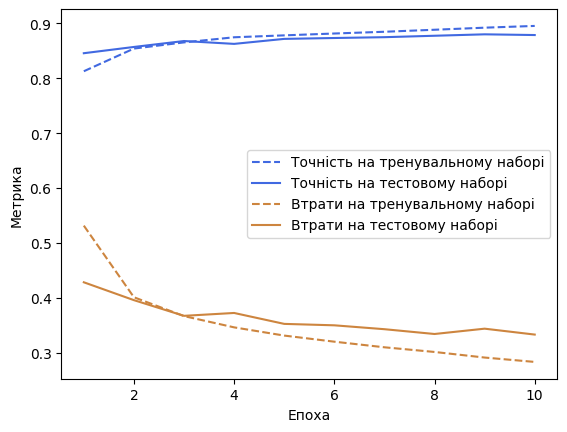

--------------------------------------------------
Тестується значення: batch_size = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 871us/step - accuracy: 0.9066 - loss: 0.2455
          тренувальні дані:   0.9070666432380676 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.8786 - loss: 0.3332
          тестові дані:       0.8798999786376953 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


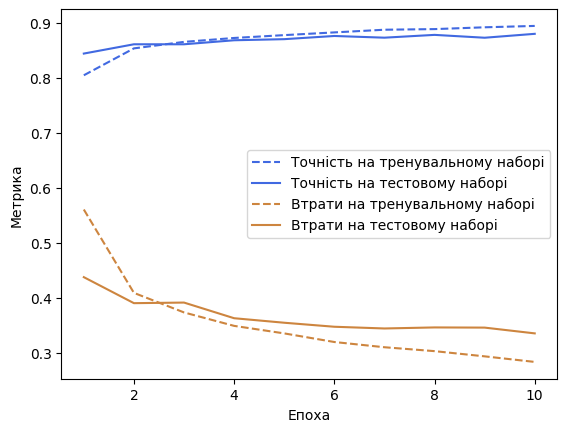

--------------------------------------------------
Тестується значення: batch_size = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 916us/step - accuracy: 0.9049 - loss: 0.2545
          тренувальні дані:   0.9045000076293945 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.8783 - loss: 0.3323
          тестові дані:       0.8762000203132629 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


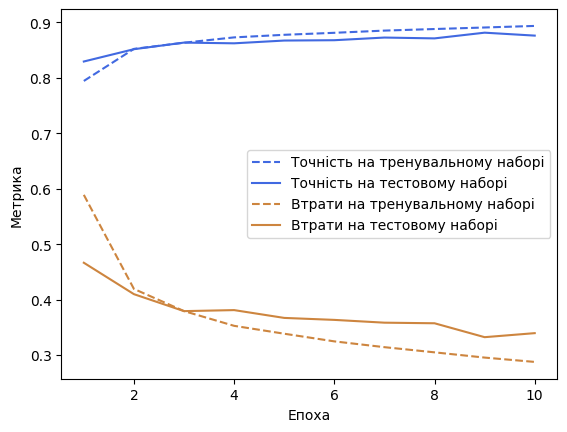

--------------------------------------------------
Тестується значення: batch_size = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 861us/step - accuracy: 0.9017 - loss: 0.2648
          тренувальні дані:   0.9014333486557007 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.8811 - loss: 0.3306
          тестові дані:       0.8780999779701233 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 256
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


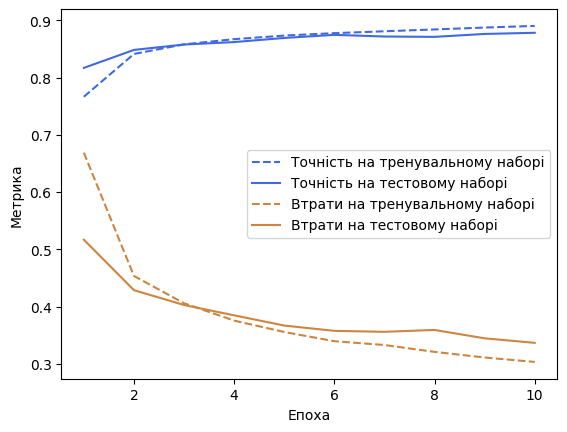

 Оптимальне значення параметра batch_size = 64
   точність на тестових даних: 0.8798999786376953

Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.0
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 928us/step - accuracy: 0.9156 - loss: 0.2276
          тренувальні дані:   0.9151666760444641 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.8812 - loss: 0.3378
          тестові дані:       0.8822000026702881 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.0
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


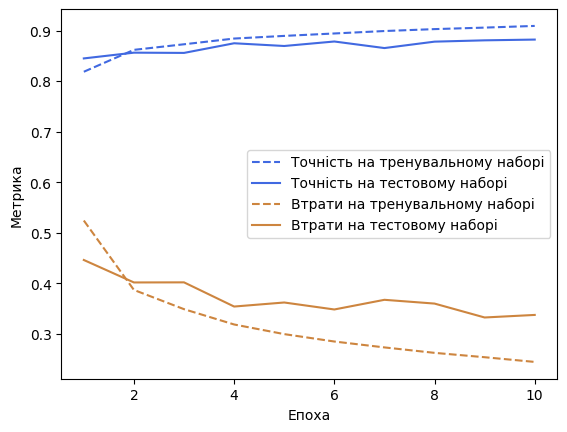

--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 809us/step - accuracy: 0.9090 - loss: 0.2449
          тренувальні дані:   0.9077500104904175 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.8793 - loss: 0.3455
          тестові дані:       0.8779000043869019 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


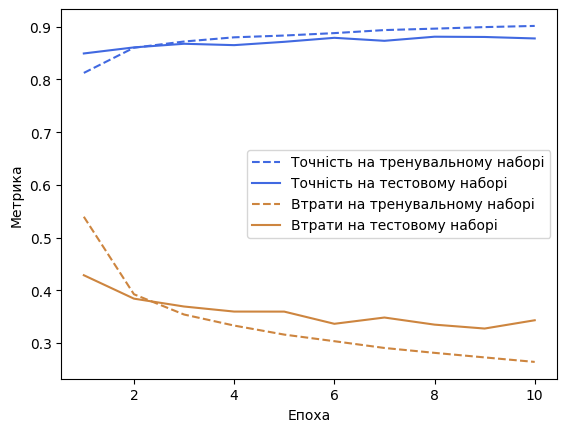

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 798us/step - accuracy: 0.9048 - loss: 0.2485
          тренувальні дані:   0.9037166833877563 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8801 - loss: 0.3333
          тестові дані:       0.8787999749183655 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


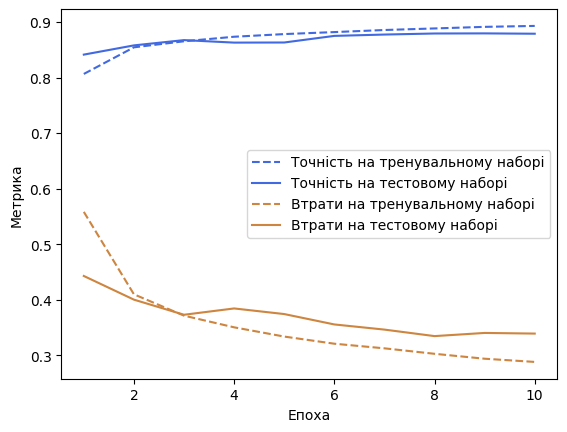

--------------------------------------------------
Тестується значення: dropout_rate = 0.3
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.9058 - loss: 0.2571
          тренувальні дані:   0.9050666689872742 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.8786 - loss: 0.3439
          тестові дані:       0.8776000142097473 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


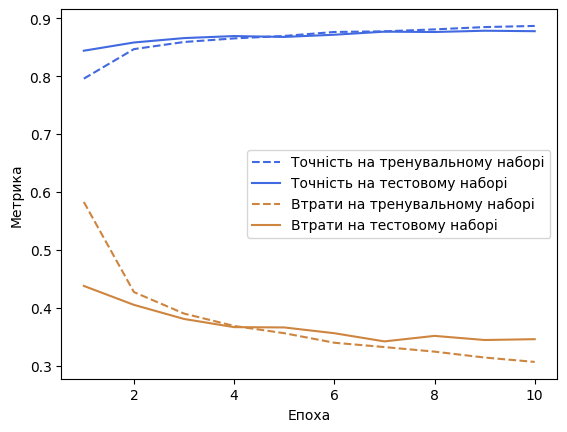

 Оптимальне значення параметра dropout_rate = 0.0
   точність на тестових даних: 0.8822000026702881

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 643us/step - accuracy: 0.9026 - loss: 0.2588
          тренувальні дані:   0.9017833471298218 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.8705 - loss: 0.3539
          тестові дані:       0.8715000152587891 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.0
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']


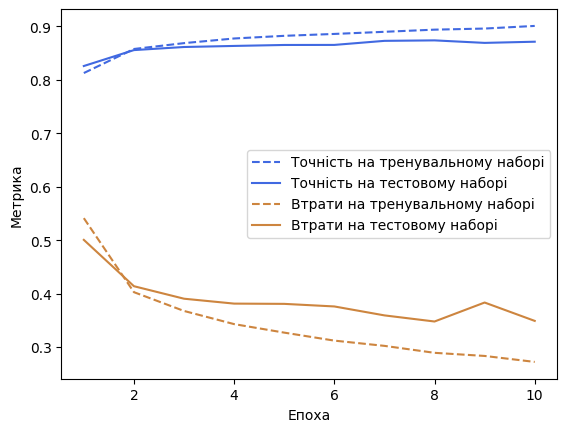

--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.9182 - loss: 0.2193
          тренувальні дані:   0.9184166789054871 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.8842 - loss: 0.3214
          тестові дані:       0.8853999972343445 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.0
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


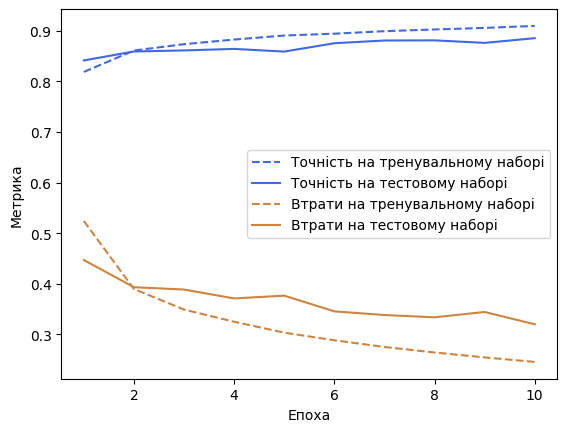

--------------------------------------------------
Тестується значення: hidden_units = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 855us/step - accuracy: 0.9174 - loss: 0.2188
          тренувальні дані:   0.9174166917800903 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.8826 - loss: 0.3338
          тестові дані:       0.8841000199317932 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.0
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


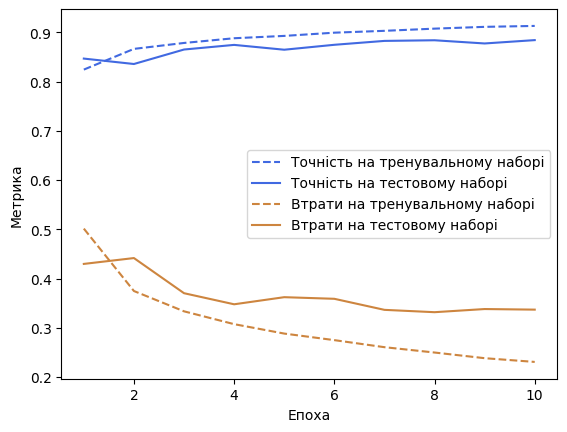

 Оптимальне значення параметра hidden_units = 128
   точність на тестових даних: 0.8853999972343445

Пошук оптимального значення параметра: loss_function 
--------------------------------------------------
Тестується значення: loss_function = sparse_categorical_crossentropy
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.9110 - loss: 0.2370
          тренувальні дані:   0.9118499755859375 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.8772 - loss: 0.3336
          тестові дані:       0.8784999847412109 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.0
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


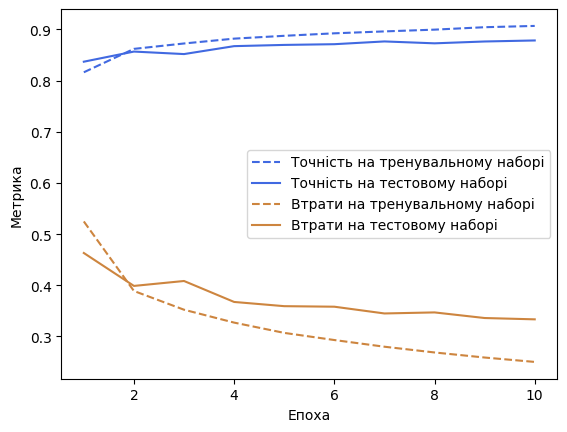

--------------------------------------------------
Тестується значення: loss_function = binary_crossentropy
--------------------------------------------------


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 10)

In [204]:
best_parameters, best_accuracy = find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    train_model_1,
)

In [ ]:
print_parameters(best_parameters, "Оптимальні параметри для model_1")
print(f" Точність:        {YELLOW}{best_accuracy}")

<div class="alert alert-block alert-info">
<b>Висновки model_1:</b> 
<p>Отримано оптимальні параметри для базової моделі з одним прихованим шаром<br>Навіть за оптимізованих параметрів точність моделі недостатня</p>
</div>

***
### **Модель для тренування 2** 
***
_Ускладнимо модель, додавши два додаткових Dense-шари (3 та 4)_

     Шари: 
1. Вхідний шар: Flatten - перетворює вхідні зображення розміром 28x28 у вектор.
2. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць та активаційною функцією, які вказані у параметрах.
3. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць в 2 рази менше, ніж у шара 2 та активаційною функцією, які вказані у параметрах.
4. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць в 4 рази менше, ніж у шара 2 та активаційною функцією, які вказані у параметрах.
5. Вихідний шар: Dense з 10 одиницями та активаційною функцією "softmax", яка використовується для класифікації на 10 класів.

_також скоротимо перелік параметрів, що досліджуються до трьох_
1. 'dropout_rate',
2. 'hidden_units',
3. 'epochs'

In [ ]:
def train_model_2(
    train_images,
    train_labels,
    test_images,
    test_labels,
    epochs=10,
    batch_size=32,
    dropout_rate=0.2,
    loss_function="sparse_categorical_crossentropy",
    optimizer="adam",
    hidden_units=128,
    activation="relu",
    metrics=["accuracy"],
    verbose=0,
):

    model = models.Sequential(
        [
            layers.Flatten(input_shape=(28, 28)),
            layers.Dense(hidden_units, activation=activation),
            layers.Dropout(dropout_rate),
            layers.Dense(int(hidden_units / 2), activation=activation),
            layers.Dropout(dropout_rate),
            layers.Dense(int(hidden_units / 4), activation=activation),
            layers.Dropout(dropout_rate),
            layers.Dense(10, activation="softmax"),
        ]
    )

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        verbose=verbose,
    )

    print("Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    # print("Точність на тренувальних даних:", train_acc)
    print("   тренувальні дані: ", YELLOW, train_acc, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    # print("Точність на тестових даних:", test_acc)
    print("   тестові дані:     ", YELLOW, test_acc, RESET)

    return model, history, test_acc, train_acc

In [ ]:
study_sequence = [
    # "batch_size",
    "dropout_rate",
    "hidden_units",
    # "loss_function",
    # "optimizer",
    # "activation",
    # "metrics",
    "epochs",
]

In [ ]:
best_parameters, best_accuracy = find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    train_model_2,
)

In [ ]:
print_parameters(best_parameters, "Оптимальні параметри для model_2")
print(f" Точність:        {YELLOW}{best_accuracy}")

<div class="alert alert-block alert-info">
<b>Висновки model_2:</b> 
<p>Отримано оптимальні параметри для ускладненої моделі з трьома прихованими шарами<br>Суттєвого покращення роботи моделі після її ускладнення <b>НЕ</b> спостерігається</p>
</div>

***
### **Модель для тренування 3** 
***

_модель підгледів в інтернеті_

In [ ]:
def train_model_3(
    train_images,
    train_labels,
    test_images,
    test_labels,
    epochs=10,
    batch_size=32,
    dropout_rate=0.2,
    loss_function="sparse_categorical_crossentropy",
    optimizer="adam",
    hidden_units=128,
    activation="relu",
    metrics=["accuracy"],
    verbose=0,
):
    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation=activation, input_shape=(28, 28, 1)),
            layers.MaxPooling2D(2, 2),
            layers.Conv2D(64, (3, 3), activation=activation),
            layers.MaxPooling2D(2, 2),
            layers.Flatten(),
            Dense(512, activation=activation),
            Dropout(dropout_rate),
            Dense(10, activation="softmax"),
        ]
    )

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        verbose=verbose,
    )

    print("          Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print("          тренувальні дані: ", YELLOW, train_acc, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print("          тестові дані:     ", YELLOW, test_acc, RESET)

    return model, history, test_acc, train_acc

In [ ]:
study_sequence = [
    # "batch_size",
    "optimizer",
    "dropout_rate",
    # "hidden_units",
    # "loss_function",
    "activation",
    # "metrics",
    # "epochs",
]

In [ ]:
best_parameters, best_accuracy = find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    train_model_3,
)

In [ ]:
print_parameters(best_parameters, "Оптимальні параметри для model_3")
print(f" Точність:        {YELLOW}{best_accuracy}")

<div class="alert alert-block alert-info">
<b>Висновки model_3:</b> 
<p>Отримано оптимальні параметри для ускладненої моделі зі згортковими шарами<br>Вдалося досягнути максимального значення точності більше 0,91</p>
</div>